In [14]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.contrib import slim

import matplotlib.pyplot as plt

import util
import gan_util
import gan
import dataset_util
import mnist_dataset

reload(util);
reload(gan_util);
reload(gan);
reload(dataset_util);
reload(mnist_dataset);

# Train

Extracting ../mnist/train-images-idx3-ubyte.gz
Extracting ../mnist/train-labels-idx1-ubyte.gz
Global step 100: g_loss = 3.36010718346, d_loss = 0.331810802221
Writing summaries
Writing checkpoint


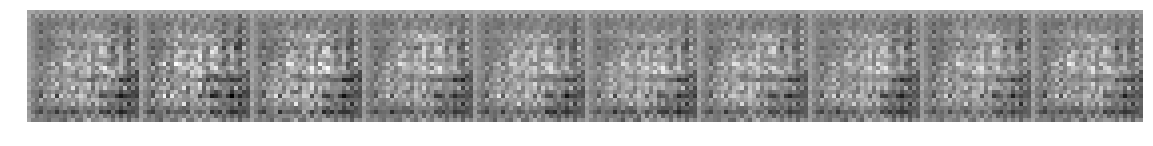

Global step 200: g_loss = 1.2064704895, d_loss = 0.180717676878
Writing summaries
Writing checkpoint


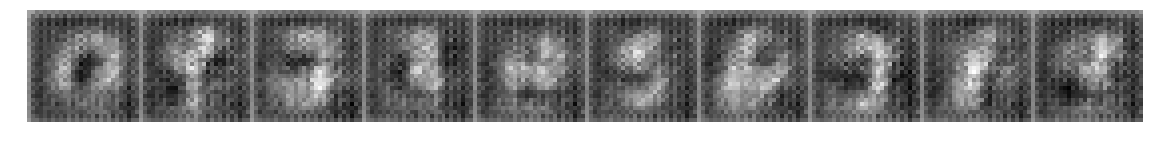

Global step 300: g_loss = 0.9638017416, d_loss = 0.332852393389
Writing summaries
Writing checkpoint


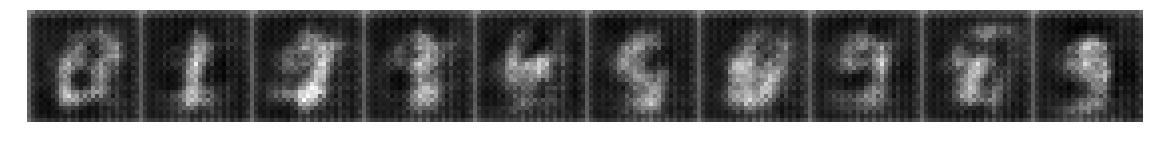

Global step 400: g_loss = 1.21989142895, d_loss = 0.525023043156
Writing summaries
Writing checkpoint


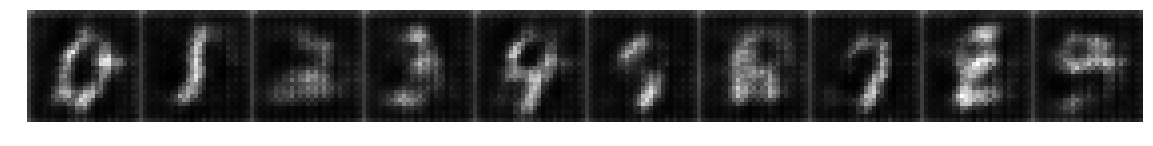

Global step 500: g_loss = 1.45840096474, d_loss = 0.511148929596
Writing summaries
Writing checkpoint


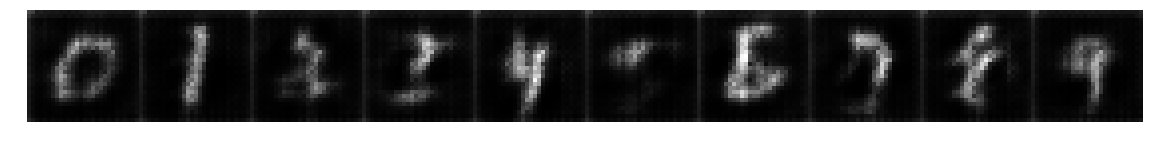

Global step 600: g_loss = 0.530509114265, d_loss = 0.1856328547
Writing summaries
Writing checkpoint


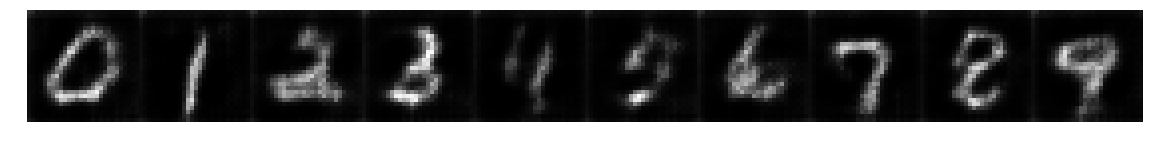

Global step 700: g_loss = 1.17348790169, d_loss = 0.441913217306
Writing summaries
Writing checkpoint


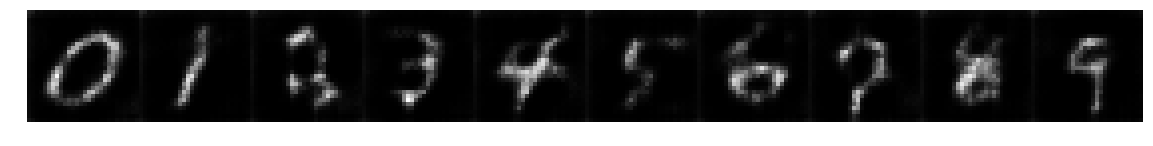

Global step 800: g_loss = 1.00106203556, d_loss = 0.272323250771
Writing summaries
Writing checkpoint


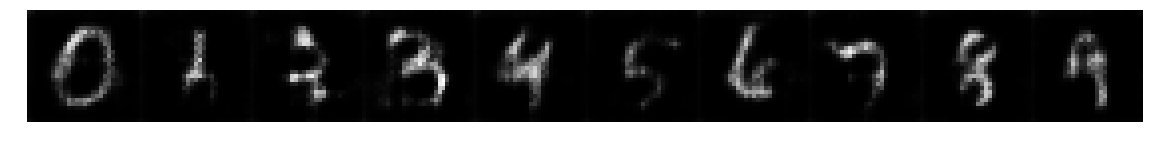

Global step 900: g_loss = 0.600336253643, d_loss = 0.385977685452
Writing summaries
Writing checkpoint


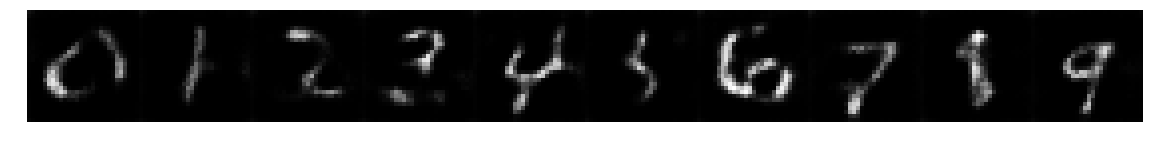

Global step 1000: g_loss = 0.585107684135, d_loss = 0.320714622736
Writing summaries
Writing checkpoint


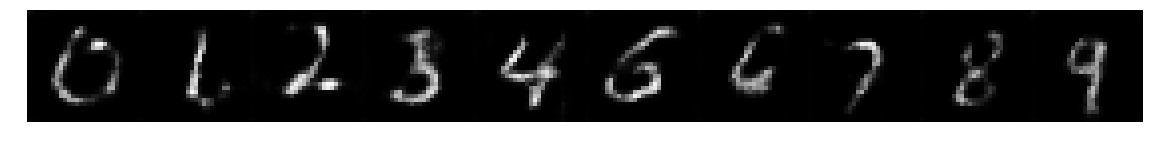

Global step 1100: g_loss = 0.799054443836, d_loss = 0.29670843482
Writing summaries
Writing checkpoint


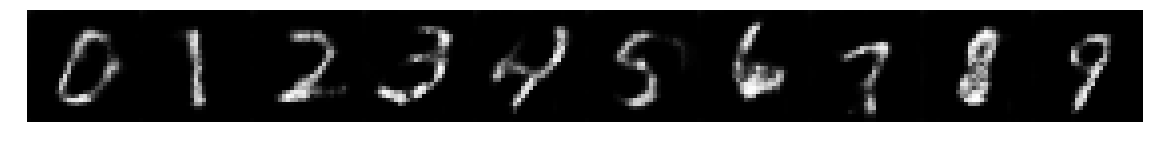

Global step 1200: g_loss = 0.507355868816, d_loss = 0.591173648834
Writing summaries
Writing checkpoint


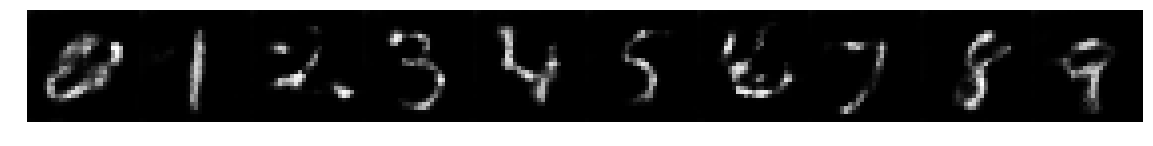

Global step 1300: g_loss = 0.699910283089, d_loss = 0.194446802139
Writing summaries
Writing checkpoint


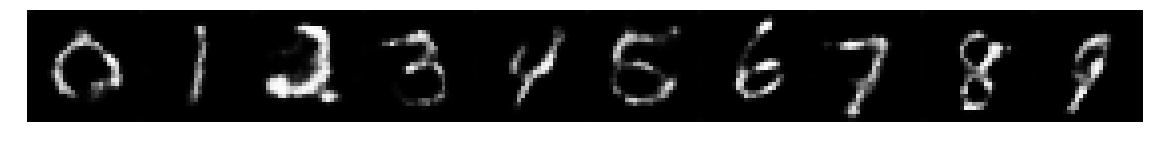

Global step 1400: g_loss = 0.487675905228, d_loss = 0.23258048296
Writing summaries
Writing checkpoint


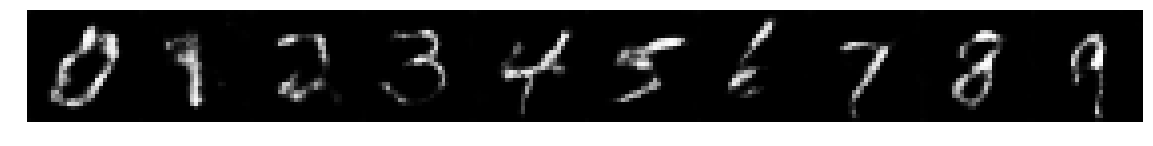

Global step 1500: g_loss = 0.339541435242, d_loss = 0.349481880665
Writing summaries
Writing checkpoint


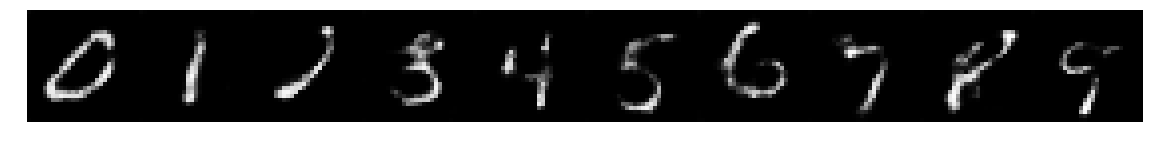

Global step 1600: g_loss = 0.639844298363, d_loss = 0.261474698782
Writing summaries
Writing checkpoint


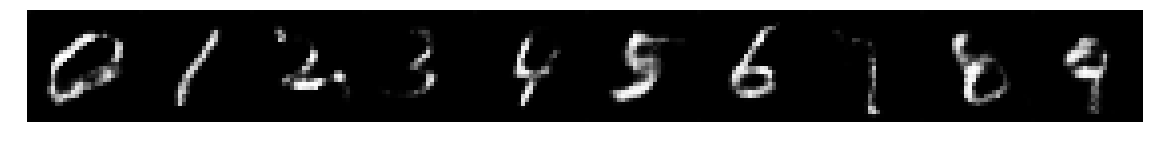

Global step 1700: g_loss = 0.60549390316, d_loss = 0.331404387951
Writing summaries
Writing checkpoint


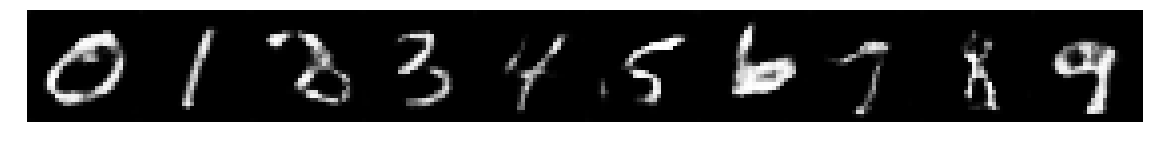

Global step 1800: g_loss = 0.669434726238, d_loss = 0.484758257866
Writing summaries
Writing checkpoint


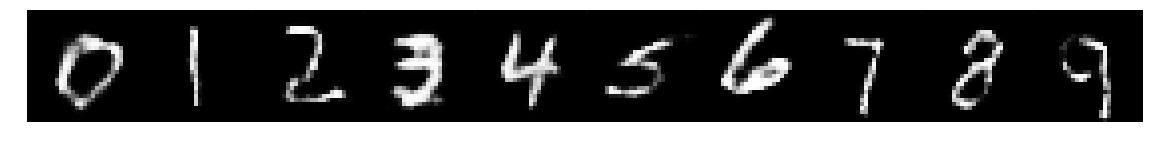

Global step 1900: g_loss = 0.536860942841, d_loss = 0.341610908508
Writing summaries
Writing checkpoint


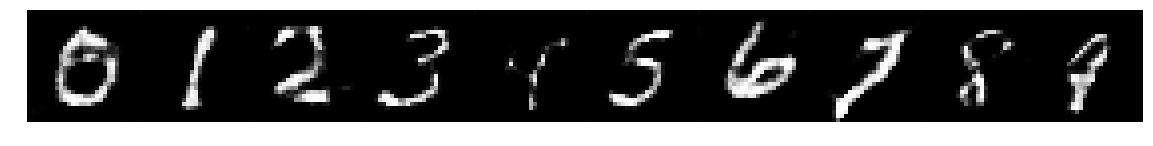

Global step 2000: g_loss = 0.445404648781, d_loss = 0.790682077408
Writing summaries
Writing checkpoint


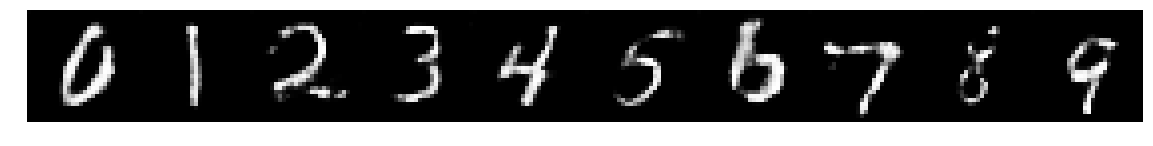

Global step 2100: g_loss = 0.616701245308, d_loss = 0.287435323
Writing summaries
Writing checkpoint


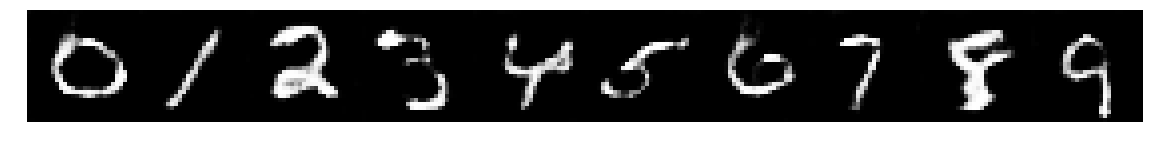

Global step 2200: g_loss = 0.6263422966, d_loss = 0.26275485754
Writing summaries
Writing checkpoint


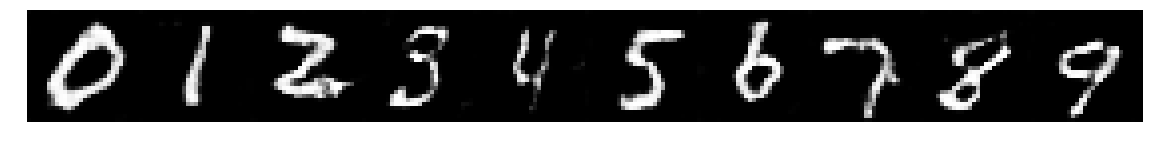

Global step 2300: g_loss = 0.562952399254, d_loss = 0.377671003342
Writing summaries
Writing checkpoint


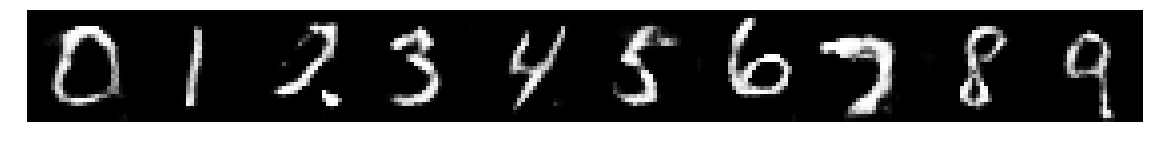

Global step 2400: g_loss = 0.452545940876, d_loss = 0.306387394667
Writing summaries
Writing checkpoint


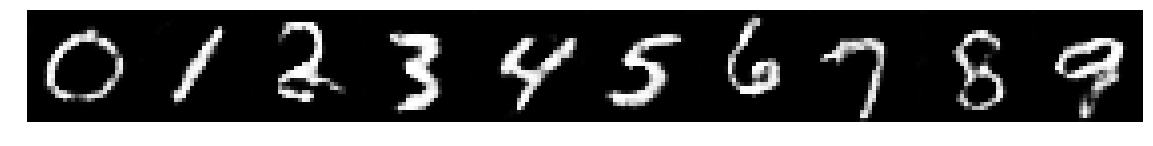

Global step 2500: g_loss = 0.453085839748, d_loss = 0.415301352739
Writing summaries
Writing checkpoint


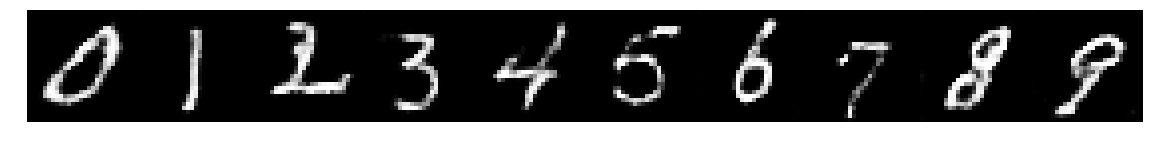

Global step 2600: g_loss = 0.6651892066, d_loss = 0.232704237103
Writing summaries
Writing checkpoint


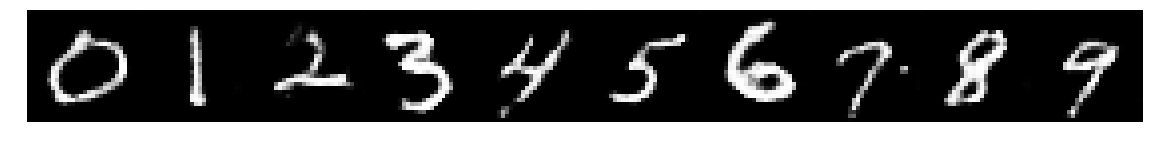

Global step 2700: g_loss = 0.575293183327, d_loss = 0.249175935984
Writing summaries
Writing checkpoint


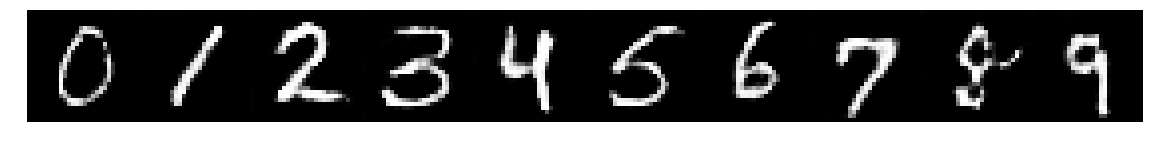

Global step 2800: g_loss = 0.533072888851, d_loss = 0.38430544734
Writing summaries
Writing checkpoint


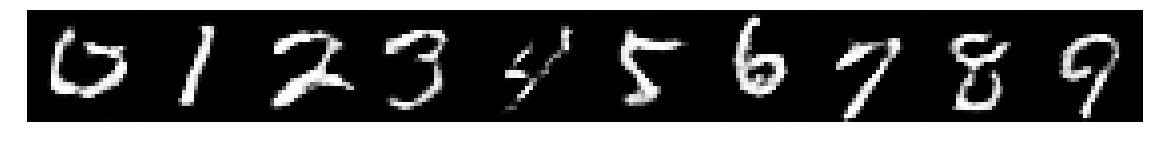

Global step 2900: g_loss = 0.544226408005, d_loss = 0.321743667126
Writing summaries
Writing checkpoint


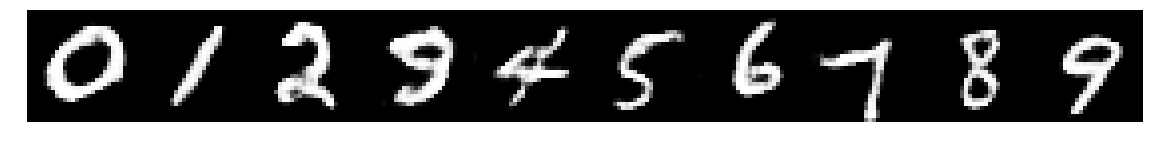

Global step 3000: g_loss = 0.453219681978, d_loss = 0.60850083828
Writing summaries
Writing checkpoint


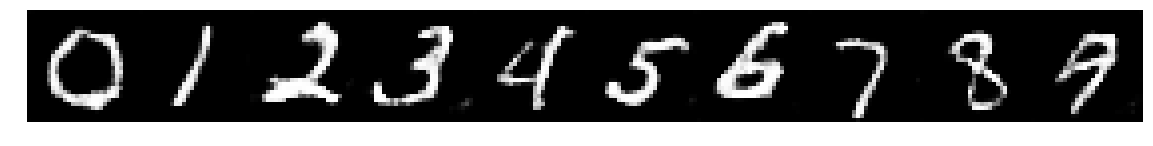

Global step 3100: g_loss = 0.316898554564, d_loss = 0.504948556423
Writing summaries
Writing checkpoint


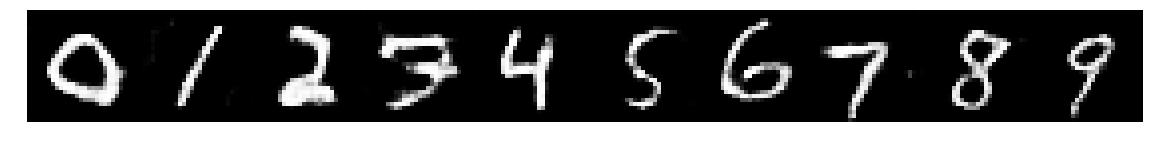

Global step 3200: g_loss = 0.597145140171, d_loss = 0.436998069286
Writing summaries
Writing checkpoint


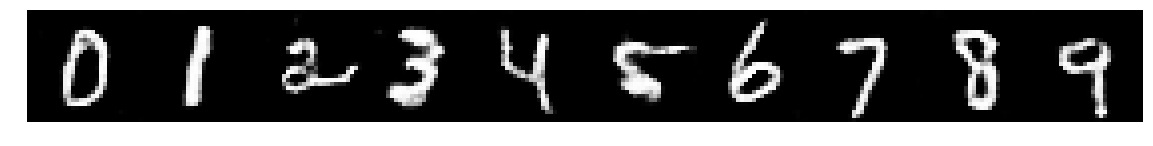

Global step 3300: g_loss = 0.799237549305, d_loss = 0.269857764244
Writing summaries
Writing checkpoint


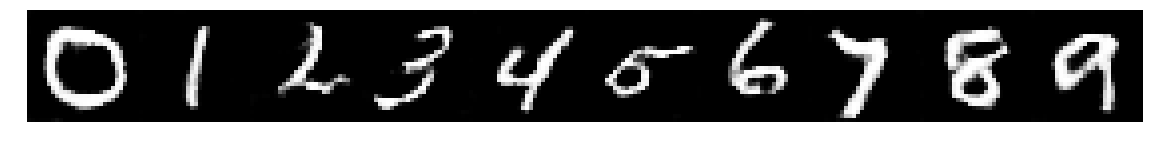

Global step 3400: g_loss = 0.602749288082, d_loss = 0.319223791361
Writing summaries
Writing checkpoint


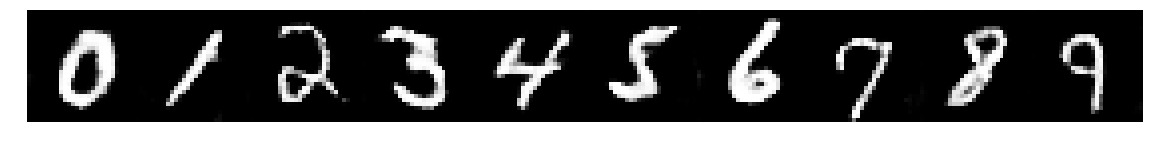

Global step 3500: g_loss = 0.728652179241, d_loss = 0.293350100517
Writing summaries
Writing checkpoint


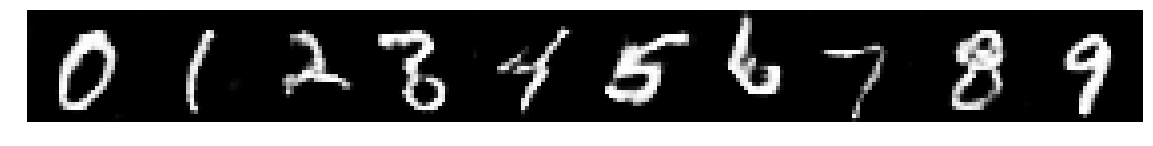

Global step 3600: g_loss = 0.681393504143, d_loss = 0.560143649578
Writing summaries
Writing checkpoint


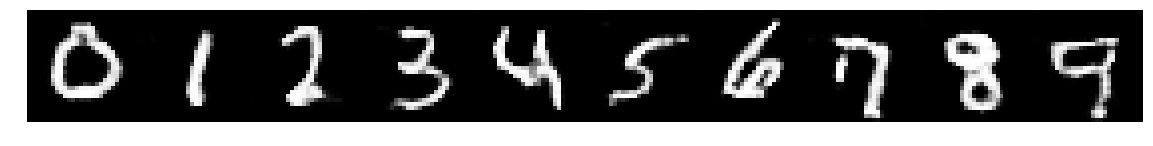

Global step 3700: g_loss = 0.551456809044, d_loss = 0.413555681705
Writing summaries
Writing checkpoint


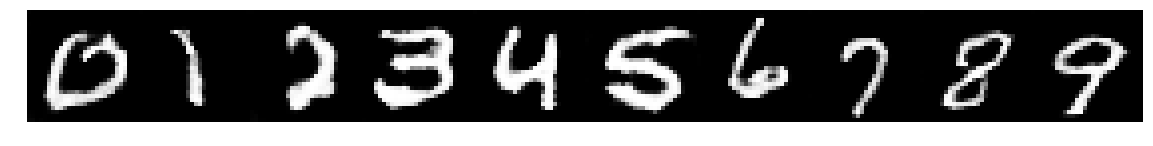

Global step 3800: g_loss = 0.719008207321, d_loss = 0.238991856575
Writing summaries
Writing checkpoint


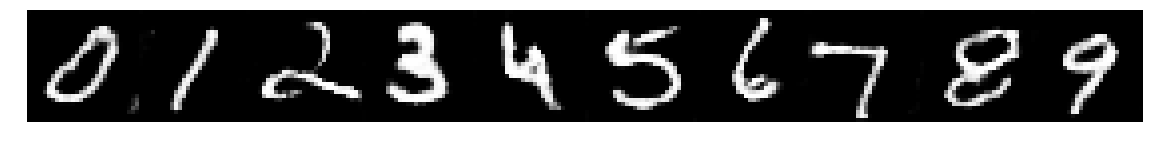

Global step 3900: g_loss = 0.500534594059, d_loss = 0.388678073883
Writing summaries
Writing checkpoint


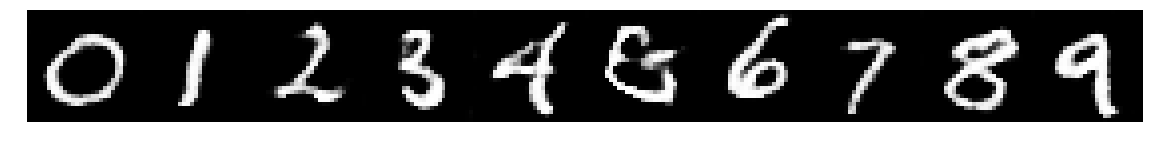

Global step 4000: g_loss = 0.687280356884, d_loss = 0.380503535271
Writing summaries
Writing checkpoint


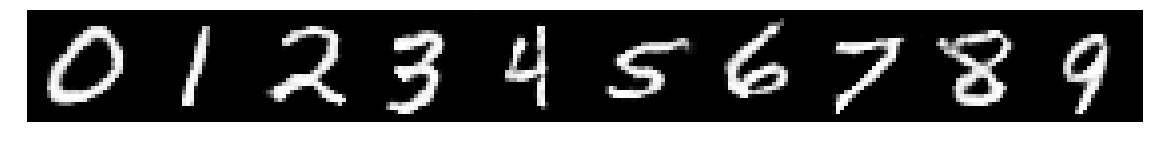

Global step 4100: g_loss = 0.699003458023, d_loss = 0.458562582731
Writing summaries
Writing checkpoint


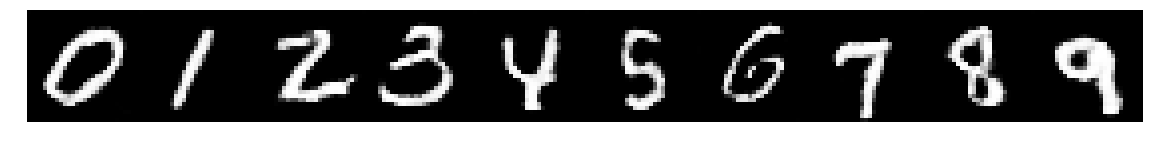

Global step 4200: g_loss = 0.576920211315, d_loss = 0.44402167201
Writing summaries
Writing checkpoint


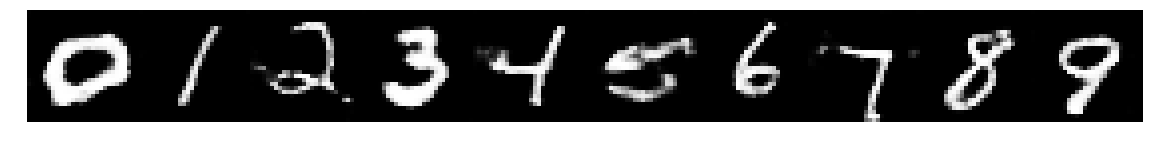

Global step 4300: g_loss = 0.483473300934, d_loss = 0.32442048192
Writing summaries
Writing checkpoint


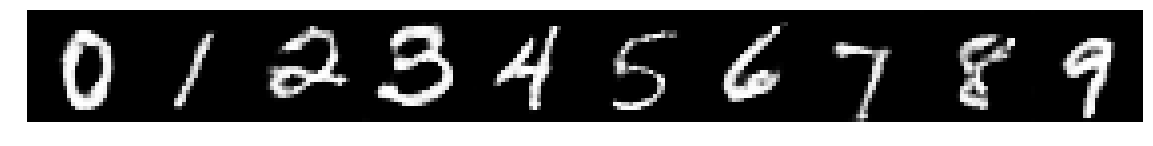

Global step 4400: g_loss = 0.585328757763, d_loss = 0.256399184465
Writing summaries
Writing checkpoint


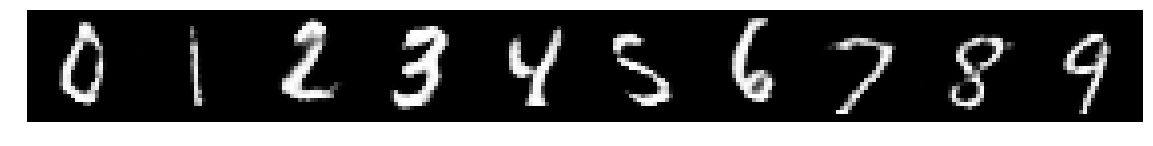

Global step 4500: g_loss = 0.748981058598, d_loss = 0.453874230385
Writing summaries
Writing checkpoint


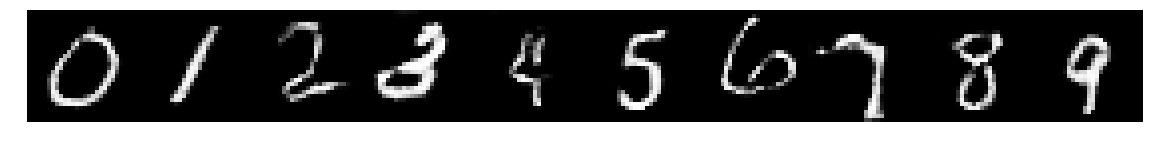

Global step 4600: g_loss = 0.421734690666, d_loss = 0.344229906797
Writing summaries
Writing checkpoint


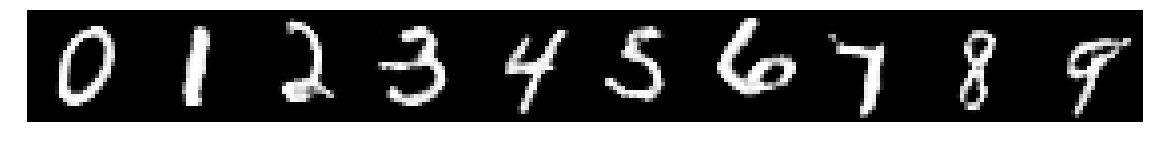

Global step 4700: g_loss = 0.547712564468, d_loss = 0.261331915855
Writing summaries
Writing checkpoint


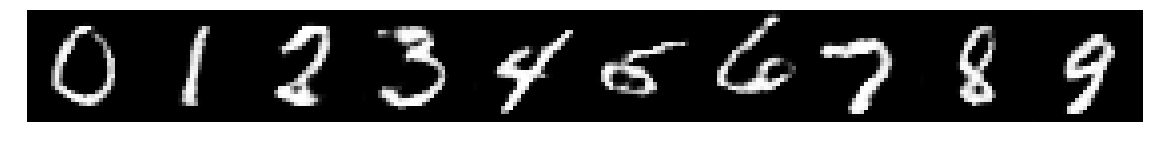

Global step 4800: g_loss = 0.544574677944, d_loss = 0.258854448795
Writing summaries
Writing checkpoint


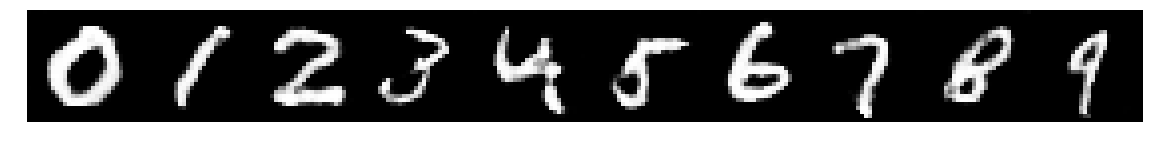

Global step 4900: g_loss = 0.681433975697, d_loss = 0.318882524967
Writing summaries
Writing checkpoint


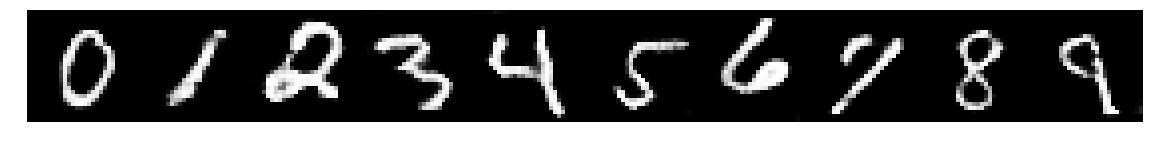

Global step 5000: g_loss = 0.735361754894, d_loss = 0.34928420186
Writing summaries
Writing checkpoint


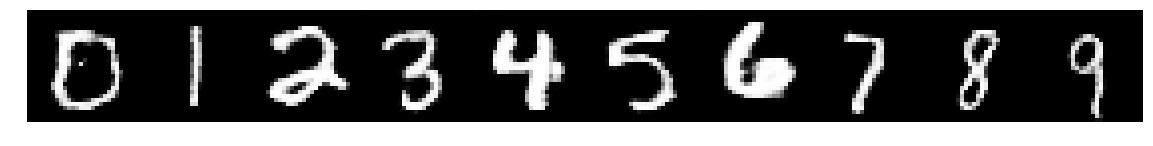

Global step 5100: g_loss = 0.557388603687, d_loss = 0.290448367596
Writing summaries
Writing checkpoint


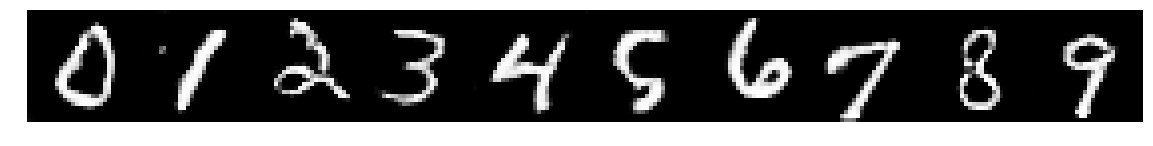

Global step 5200: g_loss = 0.804528832436, d_loss = 0.378311216831
Writing summaries
Writing checkpoint


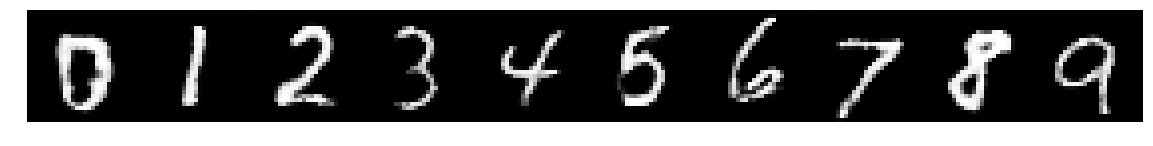

Global step 5300: g_loss = 0.856235921383, d_loss = 0.513773560524
Writing summaries
Writing checkpoint


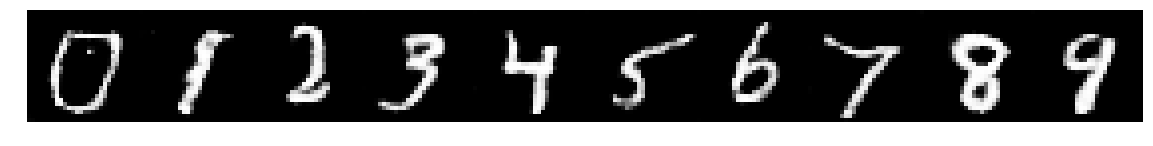

Global step 5400: g_loss = 0.655681669712, d_loss = 0.437679886818
Writing summaries
Writing checkpoint


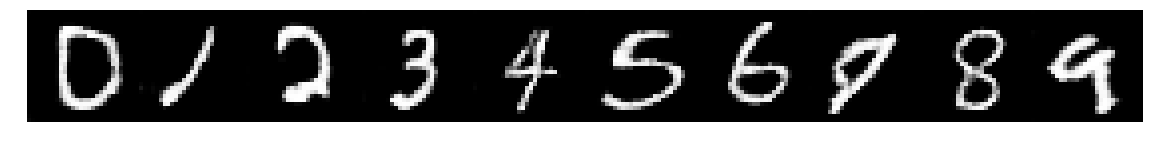

Global step 5500: g_loss = 0.595858871937, d_loss = 0.372691094875
Writing summaries
Writing checkpoint


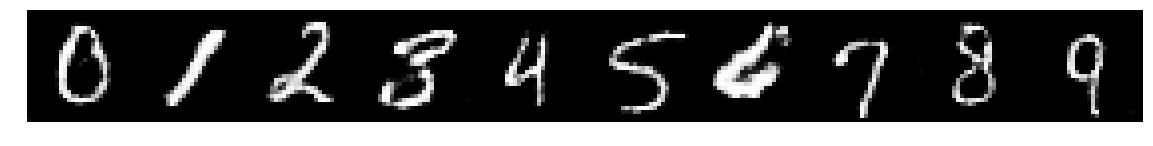

Global step 5600: g_loss = 1.05917048454, d_loss = 0.394966840744
Writing summaries
Writing checkpoint


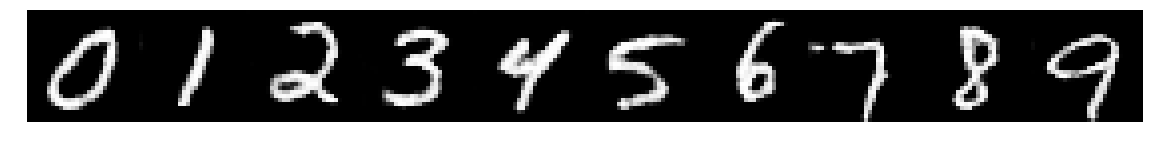

Global step 5700: g_loss = 0.748982727528, d_loss = 0.310727745295
Writing summaries
Writing checkpoint


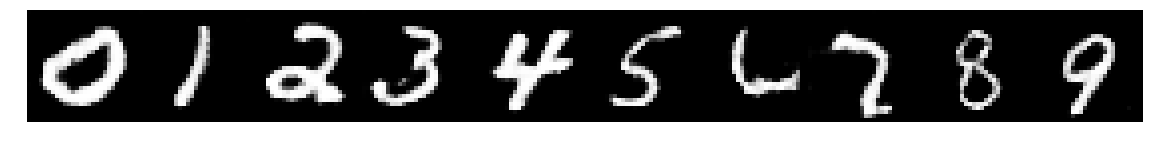

Global step 5800: g_loss = 0.631171226501, d_loss = 0.225525096059
Writing summaries
Writing checkpoint


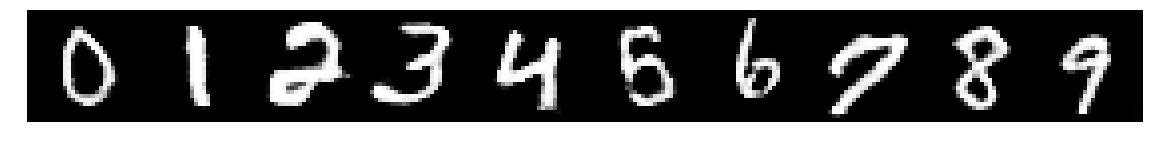

Global step 5900: g_loss = 0.670426189899, d_loss = 0.271907806396
Writing summaries
Writing checkpoint


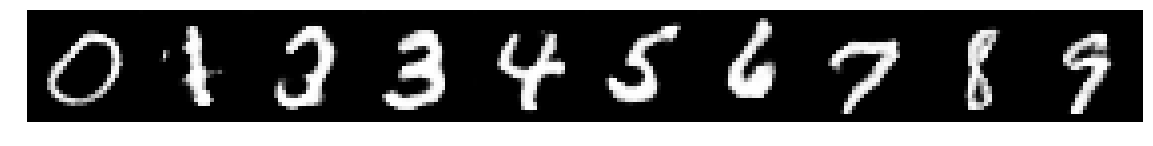

Global step 6000: g_loss = 0.5749822855, d_loss = 0.229036018252
Writing summaries
Writing checkpoint


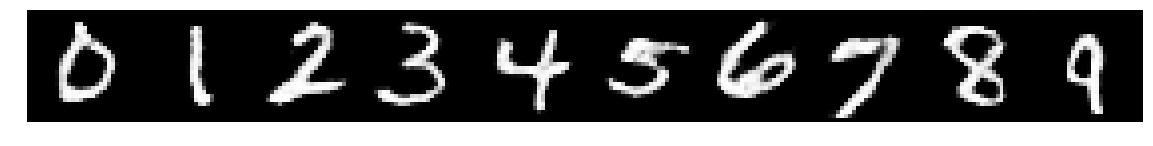

Global step 6100: g_loss = 0.673385500908, d_loss = 0.555260419846
Writing summaries
Writing checkpoint


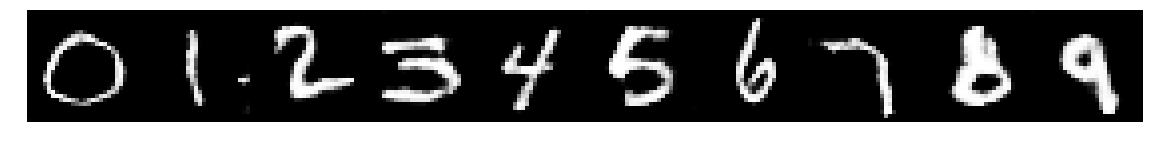

Global step 6200: g_loss = 0.748095989227, d_loss = 0.271961241961
Writing summaries
Writing checkpoint


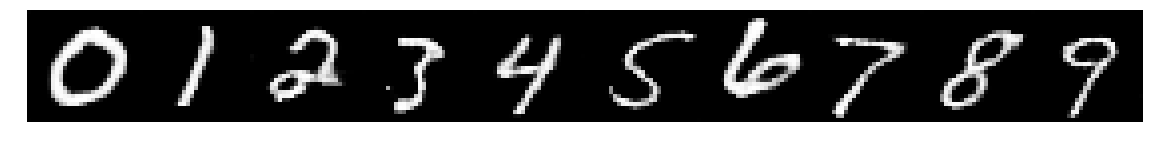

Global step 6300: g_loss = 0.318884909153, d_loss = 0.298064738512
Writing summaries
Writing checkpoint


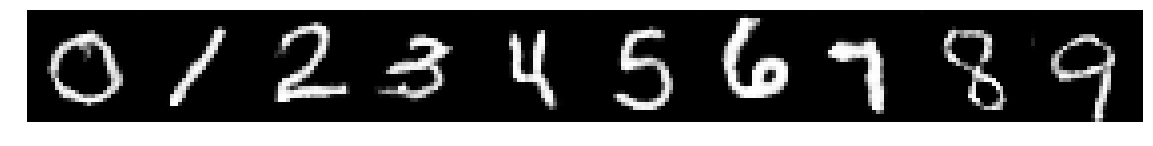

Global step 6400: g_loss = 0.688785970211, d_loss = 0.43570125103
Writing summaries
Writing checkpoint


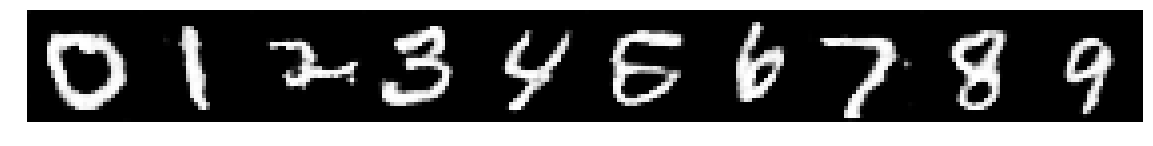

Global step 6500: g_loss = 0.293462365866, d_loss = 0.487574279308
Writing summaries
Writing checkpoint


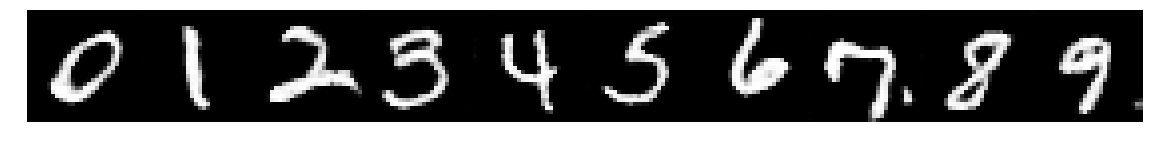

Global step 6600: g_loss = 0.568336308002, d_loss = 0.390923321247
Writing summaries
Writing checkpoint


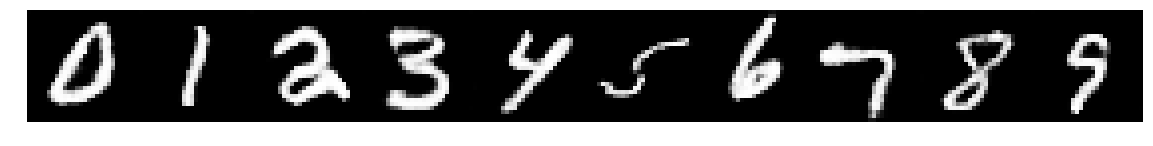

Global step 6700: g_loss = 0.37727689743, d_loss = 0.39137673378
Writing summaries
Writing checkpoint


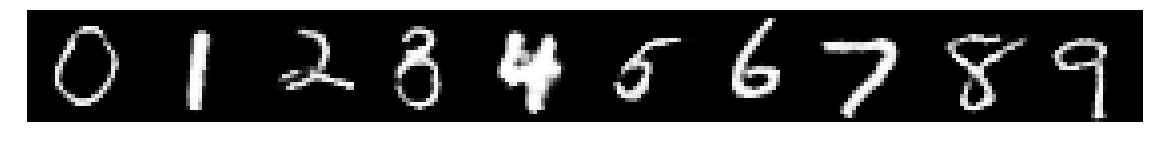

Global step 6800: g_loss = 0.490458160639, d_loss = 0.346380531788
Writing summaries
Writing checkpoint


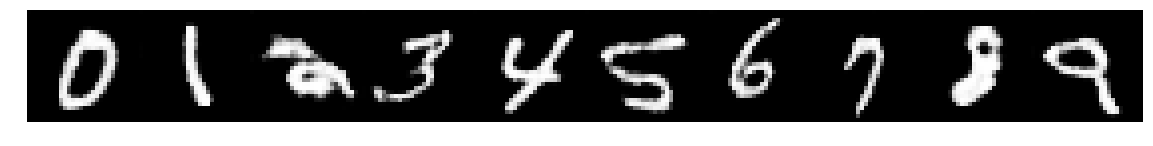

Global step 6900: g_loss = 0.559229969978, d_loss = 0.359452873468
Writing summaries
Writing checkpoint


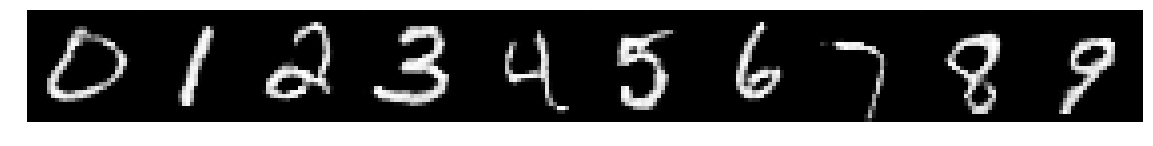

Global step 7000: g_loss = 0.812640845776, d_loss = 0.426904320717
Writing summaries
Writing checkpoint


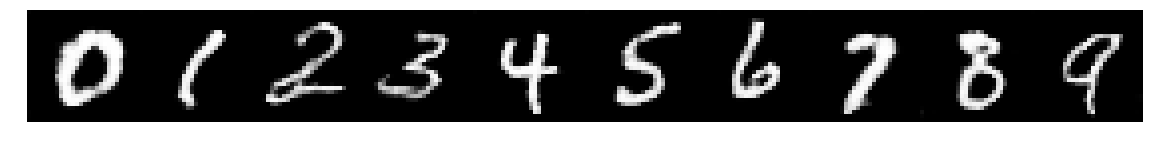

Global step 7100: g_loss = 0.589112520218, d_loss = 0.322422981262
Writing summaries
Writing checkpoint


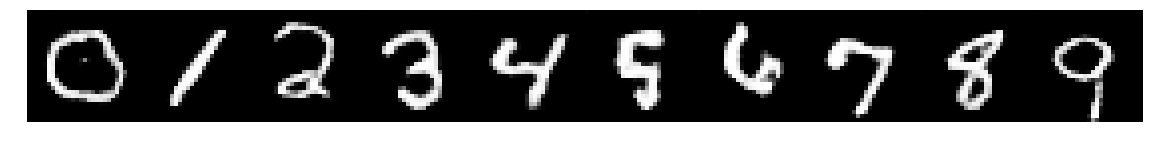

Global step 7200: g_loss = 0.510892629623, d_loss = 0.31908556819
Writing summaries
Writing checkpoint


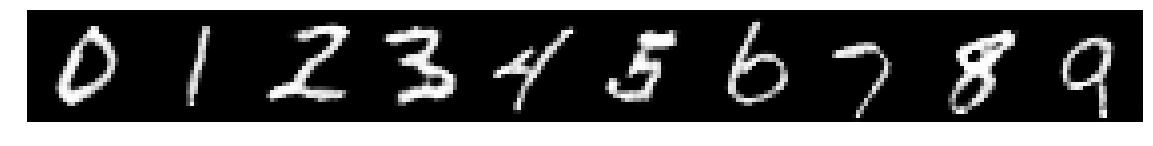

Global step 7300: g_loss = 0.482617348433, d_loss = 0.399382144213
Writing summaries
Writing checkpoint


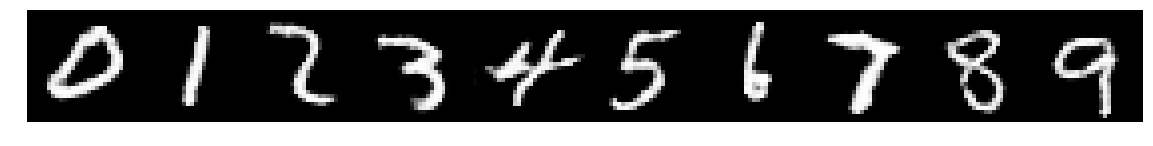

Global step 7400: g_loss = 0.550363540649, d_loss = 0.318492352962
Writing summaries
Writing checkpoint


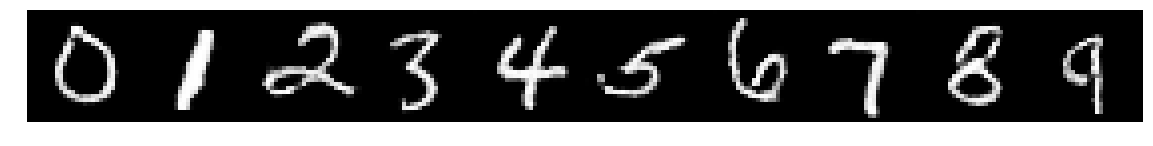

Global step 7500: g_loss = 0.924393355846, d_loss = 0.294114381075
Writing summaries
Writing checkpoint


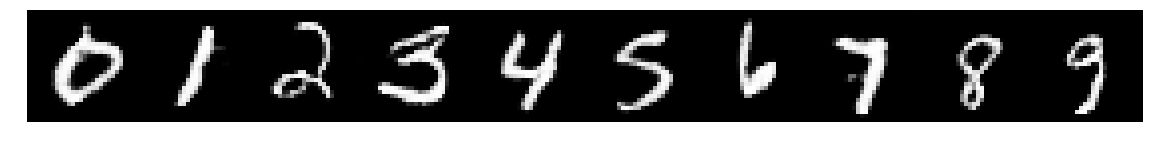

Global step 7600: g_loss = 0.469726085663, d_loss = 0.24114061892
Writing summaries
Writing checkpoint


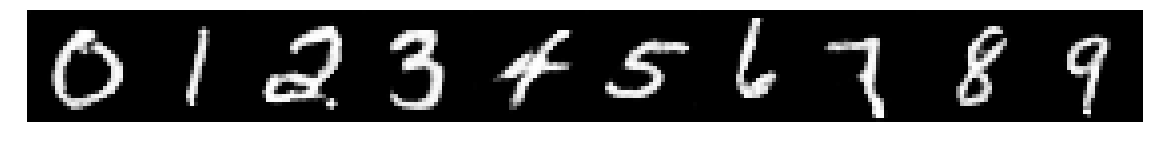

Global step 7700: g_loss = 0.606346428394, d_loss = 0.23396268487
Writing summaries
Writing checkpoint


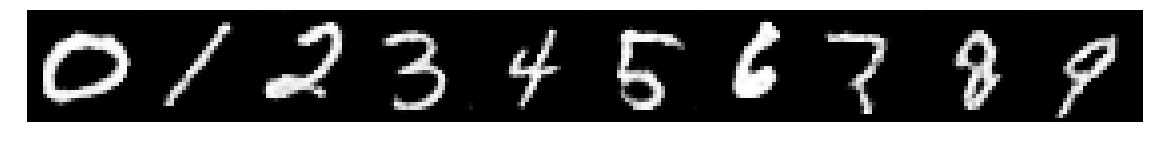

Global step 7800: g_loss = 0.491209089756, d_loss = 0.308347344398
Writing summaries
Writing checkpoint


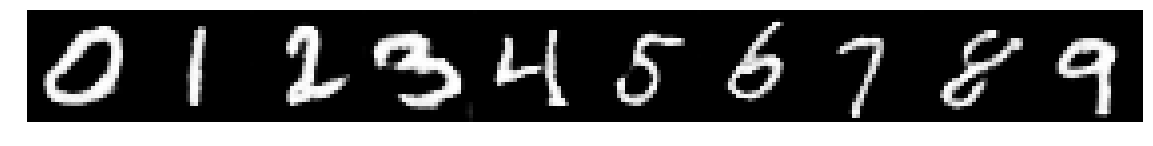

Global step 7900: g_loss = 0.529188036919, d_loss = 0.242126211524
Writing summaries
Writing checkpoint


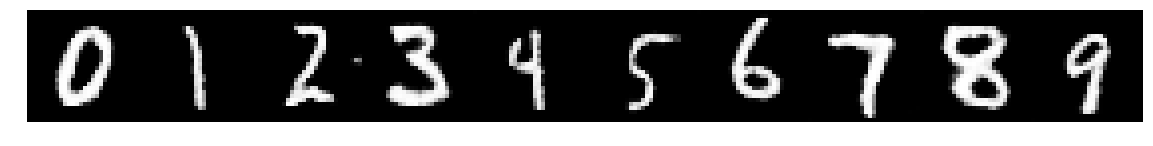

Global step 8000: g_loss = 0.545941531658, d_loss = 0.446129918098
Writing summaries
Writing checkpoint


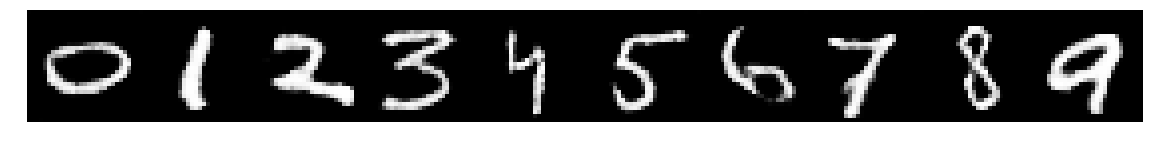

Global step 8100: g_loss = 0.295804977417, d_loss = 0.392865926027
Writing summaries
Writing checkpoint


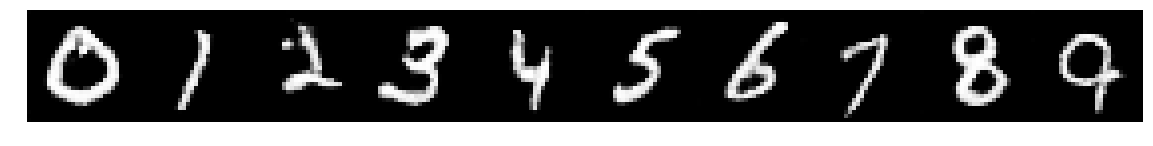

Global step 8200: g_loss = 0.655848622322, d_loss = 0.397677958012
Writing summaries
Writing checkpoint


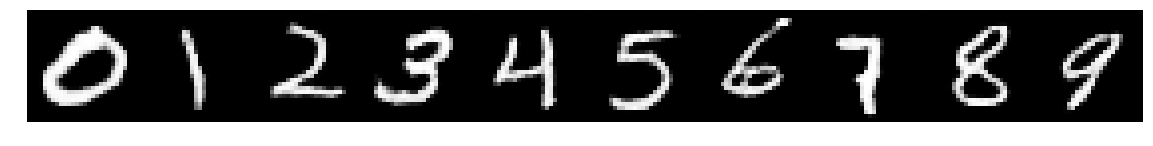

Global step 8300: g_loss = 0.38974070549, d_loss = 0.327197909355
Writing summaries
Writing checkpoint


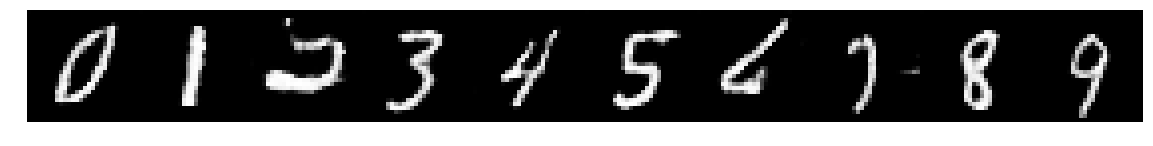

Global step 8400: g_loss = 0.650487482548, d_loss = 0.361076116562
Writing summaries
Writing checkpoint


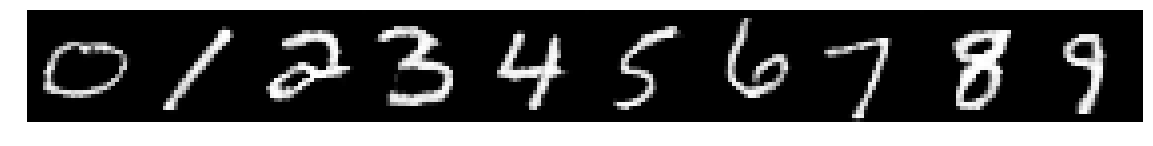

Global step 8500: g_loss = 0.510422170162, d_loss = 0.251213610172
Writing summaries
Writing checkpoint


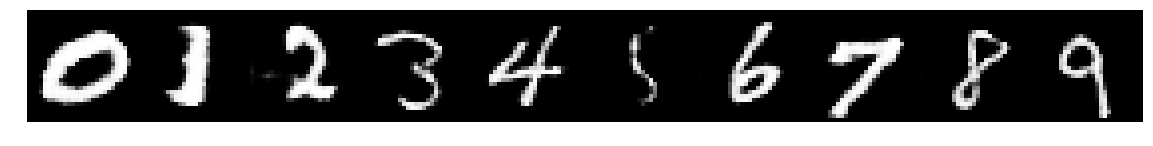

Global step 8600: g_loss = 0.635016858578, d_loss = 0.330914974213
Writing summaries
Writing checkpoint


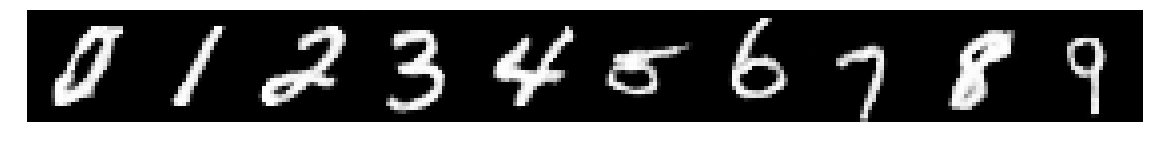

Global step 8700: g_loss = 0.339612960815, d_loss = 0.27457562089
Writing summaries
Writing checkpoint


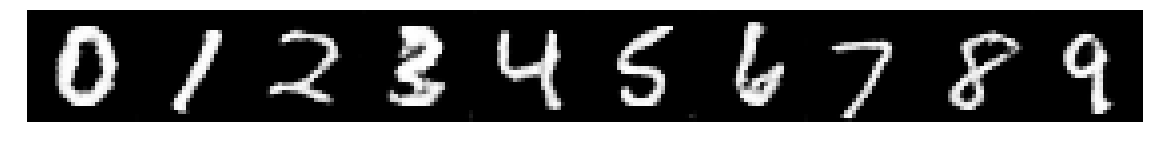

Global step 8800: g_loss = 0.73414850235, d_loss = 0.339382708073
Writing summaries
Writing checkpoint


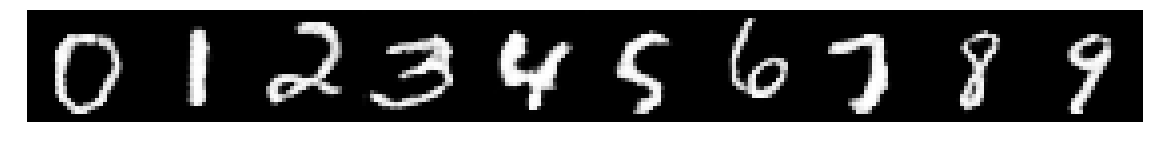

Global step 8900: g_loss = 0.713271975517, d_loss = 0.482963204384
Writing summaries
Writing checkpoint


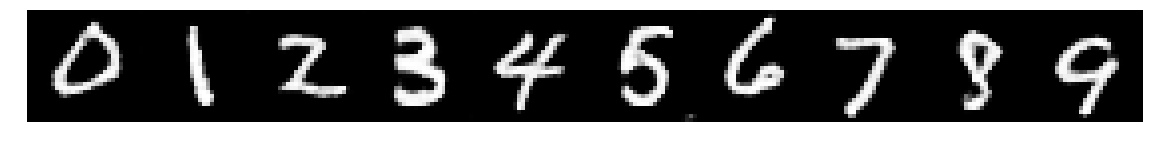

Global step 9000: g_loss = 0.521609485149, d_loss = 0.432899594307
Writing summaries
Writing checkpoint


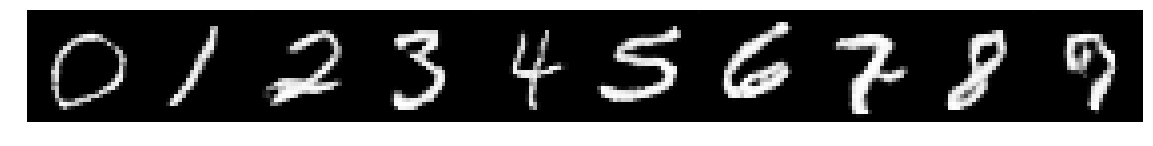

Global step 9100: g_loss = 0.757925033569, d_loss = 0.322100669146
Writing summaries
Writing checkpoint


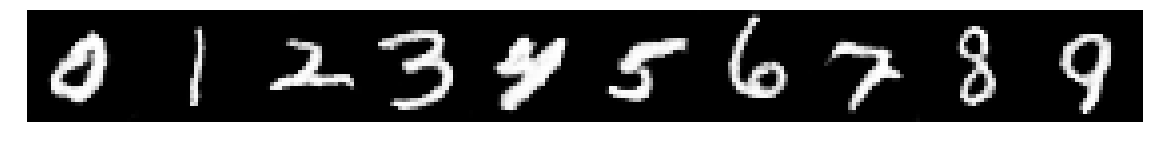

Global step 9200: g_loss = 0.556588888168, d_loss = 0.414358913898
Writing summaries
Writing checkpoint


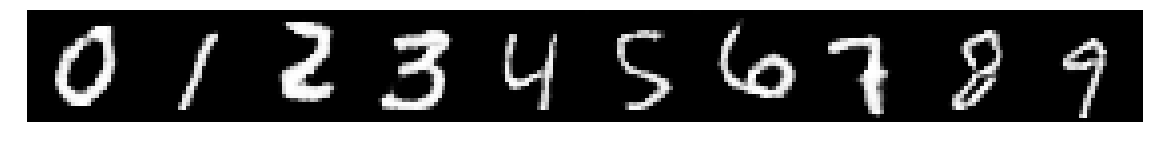

Global step 9300: g_loss = 0.689396977425, d_loss = 0.242883741856
Writing summaries
Writing checkpoint


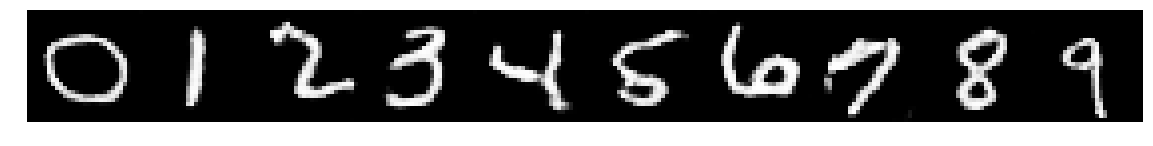

Global step 9400: g_loss = 0.613239467144, d_loss = 0.22693285346
Writing summaries
Writing checkpoint


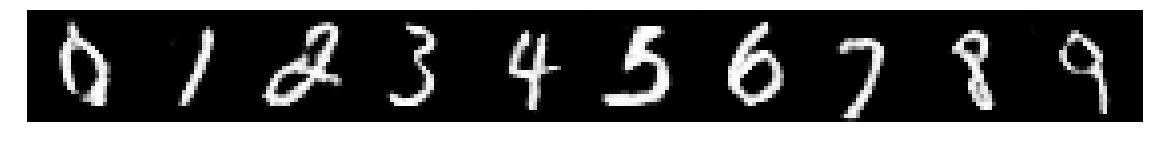

Global step 9500: g_loss = 0.577379047871, d_loss = 0.304373085499
Writing summaries
Writing checkpoint


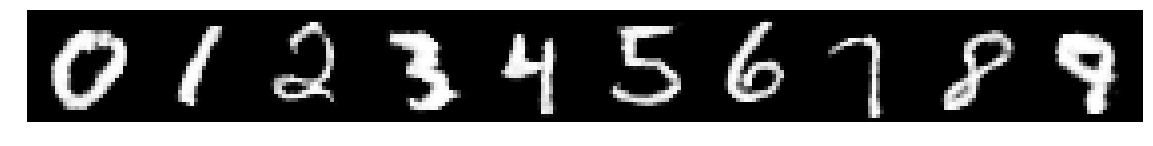

Global step 9600: g_loss = 0.744467735291, d_loss = 0.260763078928
Writing summaries
Writing checkpoint


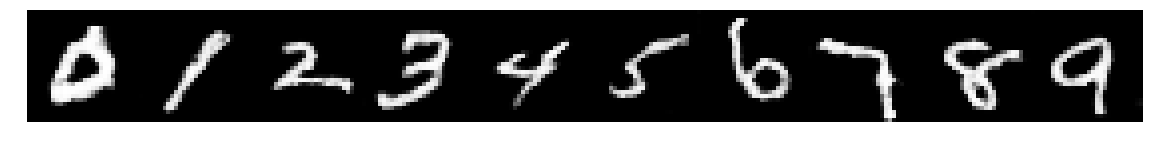

Global step 9700: g_loss = 0.795372605324, d_loss = 0.207025364041
Writing summaries
Writing checkpoint


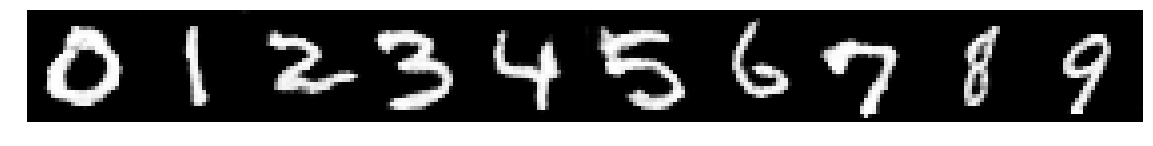

Global step 9800: g_loss = 0.638965725899, d_loss = 0.211614221334
Writing summaries
Writing checkpoint


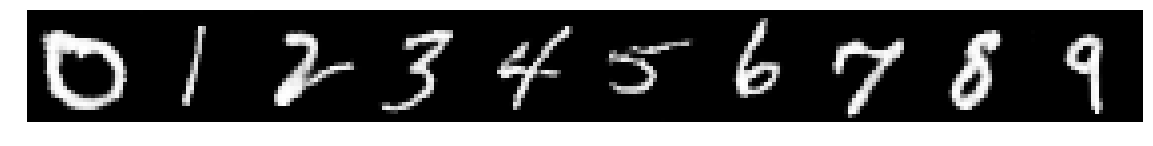

Global step 9900: g_loss = 0.549897313118, d_loss = 0.24564704299
Writing summaries
Writing checkpoint


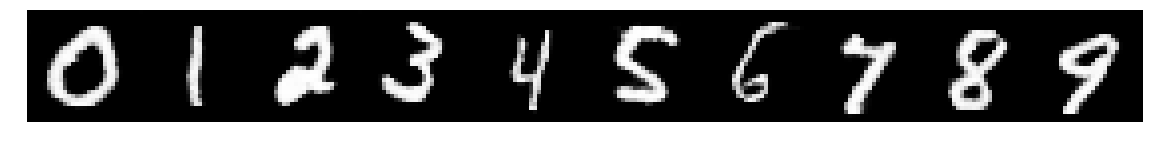

Global step 10000: g_loss = 0.532361507416, d_loss = 0.36120557785
Writing summaries
Writing checkpoint


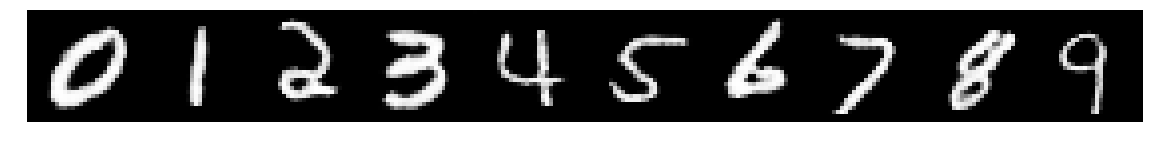

In [16]:
def plot_digits(digits):
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(
        np.concatenate([x for x in np.squeeze(digits)], axis=1), 
        cmap='gray')
    plt.show()

    
def make_generator(noise, label, is_training):
    with slim.arg_scope(
        [layers.conv2d_transpose],
        activation_fn=tf.nn.relu,
        normalizer_fn=layers.batch_norm,
        normalizer_params={'is_training': is_training,
                           'updates_collections': None}):
        top = tf.concat(
            noise.embed(cont_dims=512, cat_dims=8, name='noise') +
            label.embed(cont_dims=512, cat_dims=8, name='label'), axis=1)
        top = tf.reshape(top, [-1, 1, 1, util.get_flatten_dim(top)])
        top = layers.conv2d_transpose(top, 128, [3, 3], stride=1, padding='VALID')
        top = layers.conv2d_transpose(top, 64, [5, 5], stride=1, padding='VALID')
        top = layers.conv2d_transpose(top, 32, [5, 5], stride=2, padding='SAME')
        top = layers.conv2d_transpose(top, 1, [5, 5], stride=2, padding='SAME',
                                      activation_fn=None, normalizer_fn=None)
        top = tf.sigmoid(top)
        
        return top


def make_discriminator(data, noise, label, is_training):
    with slim.arg_scope(
        [layers.conv2d],
        activation_fn=tf.nn.relu,
        normalizer_fn=layers.batch_norm,
        normalizer_params={'is_training': is_training,
                           'updates_collections': None}):
    
        top = data
        top = layers.conv2d(top, 32, [5, 5], stride=2, padding='SAME')
        top = layers.conv2d(top, 64, [5, 5], stride=2, padding='SAME')
        top = layers.conv2d(top, 128, [5, 5], stride=1, padding='VALID')
        top = layers.flatten(top)
        top = layers.fully_connected(top, 1024)
        
        data_logit = util.linear(top, 1)
        
        return data_logit, label.linear_output(top, top)


batch_size = 32
noise_dim = 100
train_dir = 'mnist_logs'
with tf.Graph().as_default():
    dataset = mnist_dataset.Dataset(
        images_path='../mnist/train-images-idx3-ubyte.gz',
        labels_path='../mnist/train-labels-idx1-ubyte.gz')
    ds = dataset_util.repeat_shuffle_batch(
        dataset.raw, batch_size=batch_size)
    iterator = ds.make_initializable_iterator()
    next_elem = iterator.get_next()
    image, label = (next_elem[mnist_dataset.IMAGE_KEY],
                    next_elem[mnist_dataset.LABEL_KEY])
    
    real_data = util.set_first_dim(image, batch_size)
    real_label = gan_util.Signal(
        [],
        [
            gan_util.CatVector(
                util.set_first_dim(label, batch_size), 10)
        ])
    fake_noise = gan_util.Signal(
        [
            tf.random_normal(shape=(batch_size, noise_dim))
        ], [])
    fake_label = real_label
    model = gan.make_gan_model(
        make_generator,
        make_discriminator,
        fake_noise,
        fake_label,
        real_data,
        real_label)
    
    global_step = tf.contrib.framework.get_or_create_global_step()
    g_train_op, d_train_op = model.train_ops(
        tf.train.AdamOptimizer(1.0e-3, beta1=0.5),
        tf.train.AdamOptimizer(1.0e-3, beta1=0.5),
        global_step)
    
    tf.summary.scalar('generator_loss', model.generator_loss)
    tf.summary.scalar('discriminator_loss', model.discriminator_loss)
    summary_op = tf.summary.merge_all()
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer(), feed_dict=dataset.feed_dict)
        sess.run(iterator.initializer, feed_dict=dataset.feed_dict)
        
        summary_writer = tf.summary.FileWriter(
            logdir=train_dir, graph=sess.graph)
        
        with util.TensorflowQueues(sess):
            step = 0
            while step < 10000:
                _, d_loss, d_losses = sess.run([
                    d_train_op,
                    model.discriminator_loss,
                    model.discriminator_losses])
        
                _, g_loss, g_losses = sess.run([
                    g_train_op,
                    model.generator_loss,
                    model.generator_losses])
            
                step = sess.run(global_step)
                if step % 100 == 0:
                    print 'Global step {}: g_loss = {}, d_loss = {}'.format(
                        step, g_loss, d_loss)

                    print 'Writing summaries'
                    summary_proto = sess.run(summary_op)
                    summary_writer.add_summary(summary_proto, global_step=step)
                        
                    print 'Writing checkpoint'
                    saver.save(sess, os.path.join(train_dir, 'model'), global_step=step)
                    
                    feed_dict = model.test_noise.feed_dict([
                        np.random.normal(size=(10, noise_dim))
                    ], [])
                    feed_dict.update(model.test_label.feed_dict([], [
                        np.arange(10)
                    ]))
                    test_data = sess.run(model.test_data, feed_dict=feed_dict)
                    plot_digits(test_data)
                    
                    print '='*50

# Test

In [17]:
tf.reset_default_graph()
sess = tf.Session()

ckpt = tf.train.latest_checkpoint('mnist_logs')
saver = tf.train.import_meta_graph(ckpt + '.meta')
saver.restore(sess, ckpt)
    
graph = tf.get_default_graph()

print graph.get_collection(gan.TEST_NOISE_KEY)
print graph.get_collection(gan.TEST_LABEL_KEY)
print graph.get_collection(gan.TEST_DATA_KEY)

INFO:tensorflow:Restoring parameters from mnist_logs/model-10000
[<tf.Tensor 'generator_1/Placeholder:0' shape=(?, 100) dtype=float32>]
[<tf.Tensor 'generator_1/Placeholder_1:0' shape=(?,) dtype=int32>]
[<tf.Tensor 'generator_1/Sigmoid:0' shape=(?, 28, 28, 1) dtype=float32>]


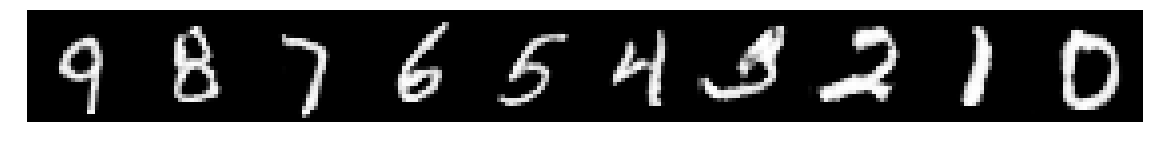

In [23]:
noise_dim = graph.get_collection(
    gan.TEST_NOISE_KEY)[0].get_shape().as_list()[1]

feed_dict = {
    graph.get_collection(gan.TEST_NOISE_KEY)[0]:
        np.random.normal(size=(10, noise_dim)),
    graph.get_collection(gan.TEST_LABEL_KEY)[0]:
        np.arange(10)[::-1]
}

test_data = sess.run(graph.get_collection(
        gan.TEST_DATA_KEY), feed_dict=feed_dict)
        
plot_digits(test_data)